In [8]:
import keras.layers as layers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.models import Model
import keras.optimizers as optim

from game.game import Game

In [39]:
INPUT_SIZE = 2
HIDDEN_SIZE = 2
OUTPUT_SIZE = 2

TEMPERATURE = 10
N_EPISODES = 800
ANALYSIS_WINDOW = 20

# OPTIMIZER = optim.Adam(0.05)
OPTIMIZER = optim.SGD(2)

In [45]:
class Agent:
    def __init__(self):
        self.build_model()
        
    def build_model(self):
        x = layers.Input(shape=[INPUT_SIZE], name="state_in")
        y = layers.Dense(HIDDEN_SIZE, activation="tanh", name="hidden")(x)
        y = layers.Dense(OUTPUT_SIZE, name="output")(y)
        y = layers.Lambda(lambda x: x / TEMPERATURE, name="temperature")(y)
        y = layers.Softmax()(y)
        
        self.model = Model(x, y)
        
        index = layers.Input(shape=[1], dtype="int32", name="index_in")
        # y_selected = layers.Lambda(lambda probs: K.gather(probs, index), output_shape=[1])(y)
        y_selected = layers.Lambda(
            lambda probs_index: tf.gather(*probs_index, axis=-1, batch_dims=1),
            name="gather")([y, index])
        
        
        def loss(target, prediction):
            return - K.log(prediction) * target
        
        self.model_train = Model([x, index], y_selected)
        self.model_train.compile(loss=loss, optimizer=OPTIMIZER)

        self.model.summary()
        self.model_train.summary()
        
        
    def predict(self, state):
        return self.model.predict(state)

    def update(self, state, target, action):
        x = [state, action]
        # print(x)
        return self.model_train.train_on_batch(x, target)

In [46]:
K.clear_session()

agent = Agent()
training = []
rewards = []

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state_in (InputLayer)        (None, 2)                 0         
_________________________________________________________________
hidden (Dense)               (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 2)                 6         
_________________________________________________________________
temperature (Lambda)         (None, 2)                 0         
_________________________________________________________________
softmax_1 (Softmax)          (None, 2)                 0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
Layer (type) 

In [47]:
for episode in range(N_EPISODES):

    # Generate input vector
    state = np.random.random([1, INPUT_SIZE])

    # Predict and sample action
    action_probs = np.squeeze(agent.predict(state))
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Evaluate action
    y_true = state[0, 0] < state[0, 1]
    y_pred = int(action == 0)
    if y_true == y_pred:
        reward = 1.
    else:
        reward = 0.
    rewards.append(reward)

    # Immediately train on the new experience
    action = np.array([action])
    reward = np.array([reward])
    loss = agent.update(state, reward, action)
    training.append(loss)

    # Print progress
    if episode and not episode % ANALYSIS_WINDOW:
        print(f"ep {episode}, \
        success_rate: {sum(rewards[-ANALYSIS_WINDOW:])/ANALYSIS_WINDOW}, \
        avg_loss: {sum(training[-ANALYSIS_WINDOW:])/ANALYSIS_WINDOW}".
        replace("    ", ""))


ep 20, success_rate: 0.65, avg_loss: 0.44459360241889956
ep 40, success_rate: 0.5, avg_loss: 0.3129827708005905
ep 60, success_rate: 0.5, avg_loss: 0.33607753217220304
ep 80, success_rate: 0.4, avg_loss: 0.2622872769832611
ep 100, success_rate: 0.35, avg_loss: 0.18313744515180588
ep 120, success_rate: 0.5, avg_loss: 0.3127574995160103
ep 140, success_rate: 0.5, avg_loss: 0.30265679210424423
ep 160, success_rate: 0.6, avg_loss: 0.32081000357866285
ep 180, success_rate: 0.8, avg_loss: 0.3077236577868462
ep 200, success_rate: 0.35, avg_loss: 0.13895749524235726
ep 220, success_rate: 0.55, avg_loss: 0.29078719615936277
ep 240, success_rate: 0.5, avg_loss: 0.14922018721699715
ep 260, success_rate: 0.75, avg_loss: 0.20790221989154817
ep 280, success_rate: 0.5, avg_loss: 0.15672945901751517
ep 300, success_rate: 0.85, avg_loss: 0.22904024124145508
ep 320, success_rate: 0.85, avg_loss: 0.18938462436199188
ep 340, success_rate: 0.65, avg_loss: 0.10662907026708127
ep 360, success_rate: 0.85, avg

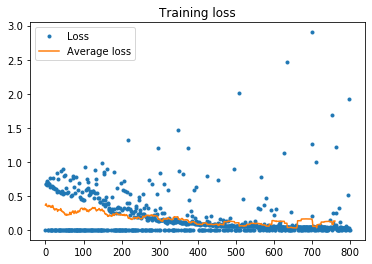

In [48]:
plt.plot(training, linestyle="None", marker=".", label="Loss")
plt.plot(np.convolve(training, np.ones((40,))/40, mode='valid'), label="Average loss")
plt.legend()
plt.title("Training loss");

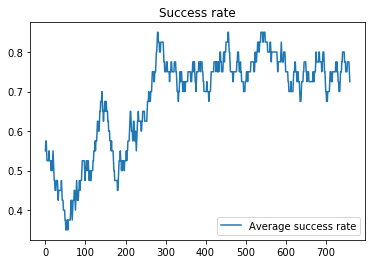

In [49]:
plt.plot(np.convolve(rewards, np.ones((40,))/40, mode='valid'), label="Average success rate");
plt.legend()
plt.title("Success rate");